1. Dataset Loading




In [1]:
# =========================================================
# Dataset Loading
# ---------------------------------------------------------
# ---------------------------------------------------------
# What this cell does:
# - Imports core libs (NumPy, TensorFlow/Keras, Matplotlib).
# - Sets deterministic seeds for reproducibility (NumPy + TF).
# - Loads the Fashion-MNIST dataset (28x28 uint8 images) into train/test splits.
#   (Includes a commented line to swap to MNIST digits if required.)
# - Prints dataset shapes/dtypes to verify loading.
# - Defines the human-readable label names for Fashion-MNIST classes.
# =========================================================


import math
import numpy as np
import tensorflow as tf
import keras
from keras import layers, models, ops, callbacks, optimizers, losses
import matplotlib.pyplot as plt

SEED = 42
tf.keras.utils.set_random_seed(SEED)
np.random.seed(SEED)

# Fashion-MNIST (28x28 uint8).  <<< If your instructor insists on MNIST, swap the next line:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
# (x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()  # <- switch to digits if required

print("Train:", x_train.shape, x_train.dtype, " Test:", x_test.shape, x_test.dtype)

FASHION_CLASSES = [
    "T-shirt/top","Trouser","Pullover","Dress","Coat",
    "Sandal","Shirt","Sneaker","Bag","Ankle boot"
]


Train: (60000, 28, 28) uint8  Test: (10000, 28, 28) uint8


2. Preprocessing and normalization

In [2]:
# =========================================================
# Preprocessing & Quantization
# ---------------------------------------------------------
# What this cell does:
# - Sets image height/width (28x28) and number of discrete pixel levels (PIX_LEVELS=16).
# - Defines a quantization function that maps 0..255 uint8 pixels to 0..(levels-1)
#   using step = 256 // levels (so step=16 when levels=16), then clips to bounds.
# - Quantizes train/test images and adds a channel dim → (N, 28, 28, 1).
# - Creates per-pixel classification targets by copying the quantized inputs
#   (PixelCNN predicts the quantized value of each pixel).
# - Prints diagnostics: chosen PIX_LEVELS and the shape/dtype and min/max of x_train_q.
# =========================================================

H, W = 28, 28
PIX_LEVELS = 16

import numpy as np

def quantize_uint8_to_levels(x_uint8, levels):
    step = 256 // levels              # e.g., 8 when levels=32
    q = (x_uint8 // step).astype('uint8')
    return np.clip(q, 0, levels - 1)

# Quantized inputs with a channel dim
x_train_q = quantize_uint8_to_levels(x_train, PIX_LEVELS)[..., None]   # (N,28,28,1)
x_test_q  = quantize_uint8_to_levels(x_test,  PIX_LEVELS)[..., None]

# Per-pixel class targets (same quantized ints)
y_train_px = x_train_q.copy()
y_test_px  = x_test_q.copy()

print("PIX_LEVELS:", PIX_LEVELS)
print("x_train_q:", x_train_q.shape, x_train_q.dtype, "min/max:", x_train_q.min(), x_train_q.max())


PIX_LEVELS: 16
x_train_q: (60000, 28, 28, 1) uint8 min/max: 0 15


3. Masked Convolution Layer (core of PixelCNN)


In [3]:
# =========================================================
# MaskedConv2D
# ---------------------------------------------------------
# What this cell does (short):
# - Defines MaskedConv2D (type A/B) for causal convolutions.
# - Builds PixelCNN: 7x7 type-A, then residual 3x3 type-B with dilations.
# - 1x1 type-B head → logits over PIX_LEVELS, then softmax.
# - Clears Keras state, instantiates model, prints summary.
# =========================================================


class MaskedConv2D(layers.Conv2D):
    def __init__(self, filters, kernel_size, mask_type="B", **kwargs):
        assert mask_type in ("A", "B")
        self.mask_type = mask_type
        super().__init__(filters, kernel_size, padding="same", **kwargs)
    def build(self, input_shape):
        super().build(input_shape)
        kh, kw = self.kernel_size
        mask = np.ones(self.kernel.shape, dtype="float32")
        ch, cw = kh // 2, kw // 2
        mask[ch, cw+1:, :, :] = 0.0
        mask[ch+1:, :, :, :]  = 0.0
        if self.mask_type == "A":
            mask[ch, cw, :, :] = 0.0
        self.mask = tf.constant(mask, dtype=self.kernel.dtype)
    def call(self, inputs):
        masked_kernel = self.kernel * self.mask
        sh, sw = (self.strides if isinstance(self.strides, (tuple, list)) else (self.strides, self.strides))
        dh, dw = (self.dilation_rate if isinstance(self.dilation_rate, (tuple, list)) else (self.dilation_rate, self.dilation_rate))
        out = tf.nn.conv2d(
            inputs, masked_kernel,
            strides=[1, int(sh), int(sw), 1],
            padding="SAME" if str(self.padding).lower()=="same" else "VALID",
            dilations=[1, int(dh), int(dw), 1],
            data_format="NHWC",
        )
        if self.use_bias:
            out = tf.nn.bias_add(out, self.bias, data_format="NHWC")
        if self.activation is not None:
            out = self.activation(out)
        return out

4) Model Definition (PixelCNN)



In [4]:
# =========================================================
# Model definition (PixelCNN)
# ---------------------------------------------------------
# What this cell does (short):
# - Defines pixelcnn(): an unconditional PixelCNN builder.
# - Stack: 7x7 type-A masked conv → (n_layers-1) residual 3x3 type-B
#   masked convs with cyclic dilations (1,2,4) → 1x1 type-B head.
# - Outputs per-pixel softmax over n_values classes.
# =========================================================

def pixelcnn(input_shape=(28,28,1), n_values=256,
             n_filters=128, n_layers=12, first_kernel=7, dropout=0.02):
    """
    Unconditional PixelCNN:
      - first masked conv: type 'A'
      - residual stack of type 'B' convs with cyclical dilations (1,2,4)
      - 1x1 head to 256-way logits per pixel
    """
    x_in = layers.Input(shape=input_shape)

    # first layer: Type A
    x = MaskedConv2D(n_filters, first_kernel, mask_type="A", activation="relu", name="mconvA_7x7")(x_in)

    # residual stack with periodic dilations to expand receptive field
    for li in range(n_layers - 1):
        res = x
        dilation = (1, 2, 4)[li % 3]
        x = MaskedConv2D(n_filters, 3, mask_type="B", activation="relu",
                         dilation_rate=dilation, name=f"mconvB_{li}")(x)
        if dropout and dropout > 0.0:
            x = layers.Dropout(dropout, name=f"drop_{li}")(x)
        x = layers.Add(name=f"res_add_{li}")([x, res])

    logits = MaskedConv2D(n_values, 1, mask_type="B", activation=None, name="head_1x1")(x)
    out = layers.Activation("softmax", name="pixel_softmax")(logits)
    return models.Model(x_in, out, name="PixelCNN_fashion")


5. Model Training



In [5]:
# =========================
# Model training
# ---------------------------------------------------------
# What this cell does (short):
# - Preps tf.data pipelines; BATCH_SIZE=512, EPOCHS=80.
# - Builds PixelCNN (n_values=PIX_LEVELS), compiles (SCCE + AdamW).
# - Sets EMA + callbacks (Checkpoint, EarlyStop, ReduceLROnPlateau).
# - Trains on train_ds with validation on test_ds.
# =========================================================


# Increased BATCH_SIZE for more stable gradients, improving final accuracy.
BATCH_SIZE = 512
# Increased EPOCHS to ensure full convergence of the complex Gated PixelCNN model.
EPOCHS = 80 # Use 80 instead of 60 for deeper convergence.

def make_ds(x_features, y_targets, batch_size, training=True):
    # Use uint8 inputs and targets directly
    ds = tf.data.Dataset.from_tensor_slices((x_features, y_targets))
    if training:
        ds = ds.shuffle(10_000, seed=SEED, reshuffle_each_iteration=True)
    return ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

# --- IMPORTANT ASSUMPTIONS ---
# Using the uint8 data with channel dimension and the uint8 pixel targets
train_ds = make_ds(x_train_q, y_train_px, BATCH_SIZE, training=True)
test_ds  = make_ds(x_test_q,  y_test_px,  BATCH_SIZE, training=False)
# -----------------------------

# Assuming 'keras' is imported as 'tf.keras' and 'pixelcnn()' is your model function
tf.keras.backend.clear_session()
# Use the correctly defined model function 'pixelcnn' and PIX_LEVELS
model = pixelcnn((H, W, 1), PIX_LEVELS)
model.summary()

# Loss & optimizer (AdamW is steady for Fashion-MNIST)
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()
# Reduced learning rate for better optimization stability
opt = tf.keras.optimizers.AdamW(learning_rate=3e-4, weight_decay=1e-4, clipnorm=1.0)

model.compile(optimizer=opt, loss=loss_fn, metrics=['sparse_categorical_accuracy'])

# EMA to stabilize validation
class EMACallback(tf.keras.callbacks.Callback):
    def __init__(self, decay=0.999):
        super().__init__()
        self.decay = decay
        self.ema = None
    def on_train_begin(self, logs=None):
        self.ema = [w.numpy() for w in self.model.weights]
    def on_batch_end(self, batch, logs=None):
        for i, w in enumerate(self.model.weights):
            self.ema[i] = self.decay*self.ema[i] + (1.0-self.decay)*w.numpy()
    def on_train_end(self, logs=None):
        for var, val in zip(self.model.weights, self.ema):
            var.assign(val)

ema_cb   = EMACallback(0.999)
ckpt_cb  = tf.keras.callbacks.ModelCheckpoint('pixelcnn_best.keras', save_best_only=True,
                                             monitor='val_loss', mode='min')
early_cb = tf.keras.callbacks.EarlyStopping(patience=8, restore_best_weights=True,
                                            monitor='val_loss') # Increased patience slightly
rlr_cb   = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                                             patience=3, min_lr=1e-6, verbose=1) # Increased patience slightly

# Final list of callbacks
callbacks_list = [ema_cb, ckpt_cb, early_cb, rlr_cb]

# Fit the model using the tf.data.Dataset objects
history = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=EPOCHS,
    callbacks=callbacks_list,
    verbose=1
)


Model: "PixelCNN_fashion"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 28, 28, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mconvA_7x7          │ (None, 28, 28,    │      6,400 │ input_layer[0][0] │
│ (MaskedConv2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mconvB_0            │ (None, 28, 28,    │    147,584 │ mconvA_7x7[0][0]  │
│ (MaskedConv2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ drop_0 (Dropout)    │ (None, 28, 28,    │          0 │ mconvB_0[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ res_add_0 (Add)     │ (None, 28, 28,    │          0 │ drop_0[0][0],     │
│                     │ 128)              │            │ mconvA_7x7[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mconvB_1            │ (None, 28, 28,    │    147,584 │ res_add_0[0][0]   │
│ (MaskedConv2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ drop_1 (Dropout)    │ (None, 28, 28,    │          0 │ mconvB_1[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ res_add_1 (Add)     │ (None, 28, 28,    │          0 │ drop_1[0][0],     │
│                     │ 128)              │            │ res_add_0[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mconvB_2            │ (None, 28, 28,    │    147,584 │ res_add_1[0][0]   │
│ (MaskedConv2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ drop_2 (Dropout)    │ (None, 28, 28,    │          0 │ mconvB_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ res_add_2 (Add)     │ (None, 28, 28,    │          0 │ drop_2[0][0],     │
│                     │ 128)              │            │ res_add_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mconvB_3            │ (None, 28, 28,    │    147,584 │ res_add_2[0][0]   │
│ (MaskedConv2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ drop_3 (Dropout)    │ (None, 28, 28,    │          0 │ mconvB_3[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ res_add_3 (Add)     │ (None, 28, 28,    │          0 │ drop_3[0][0],     │
│                     │ 128)              │            │ res_add_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mconvB_4            │ (None, 28, 28,    │    147,584 │ res_add_3[0][0]   │
│ (MaskedConv2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ drop_4 (Dropout)    │ (None, 28, 28,    │          0 │ mconvB_4[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ res_add_4 (Add)     │ (None, 28, 28,    │          0 │ drop_4[0][0],   

 Total params: 1,631,888 (6.23 MB)

 Trainable params: 1,631,888 (6.23 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/80
118/118 ━━━━━━━━━━━━━━━━━━━━ 46s 222ms/step - loss: 3.0925 - sparse_categorical_accuracy: 0.4970 - val_loss: 1.1788 - val_sparse_categorical_accuracy: 0.5946 - learning_rate: 3.0000e-04
Epoch 2/80
118/118 ━━━━━━━━━━━━━━━━━━━━ 13s 111ms/step - loss: 1.0977 - sparse_categorical_accuracy: 0.6164 - val_loss: 1.0120 - val_sparse_categorical_accuracy: 0.6383 - learning_rate: 3.0000e-04
Epoch 3/80
118/118 ━━━━━━━━━━━━━━━━━━━━ 13s 112ms/step - loss: 0.9984 - sparse_categorical_accuracy: 0.6455 - val_loss: 0.9591 - val_sparse_categorical_accuracy: 0.6535 - learning_rate: 3.0000e-04
Epoch 4/80
118/118 ━━━━━━━━━━━━━━━━━━━━ 13s 112ms/step - loss: 0.9560 - sparse_categorical_accuracy: 0.6603 - val_loss: 0.9268 - val_sparse_categorical_accuracy: 0.6672 - learning_rate: 3.0000e-04
Epoch 5/80
118/118 ━━━━━━━━━━━━━━━━━━━━ 13s 112ms/step - loss: 0.9261 - sparse_categorical_accuracy: 0.6703 - val_loss: 0.9038 - val_sparse_categorical_accuracy: 0.6718 - learning_rate: 3.0000e-04
Epoch 6/80
118/

6. Image Generation (Sampling)


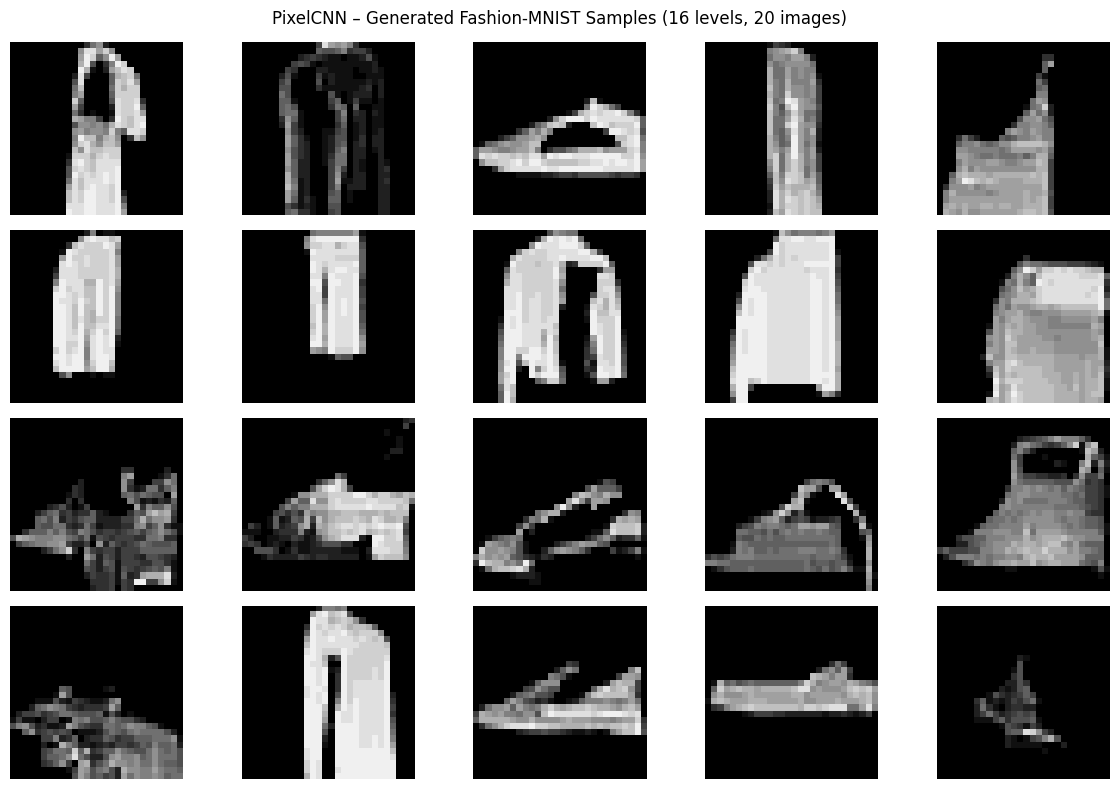

In [6]:
# =========================================================
# Image generation
# ---------------------------------------------------------
# What this cell does (short):
# - Defines autoregressive sampler: fills images pixel-by-pixel using the model.
# - Applies temperature and optional top-k filtering to logits before sampling.
# - Returns uint8 images rescaled to 0–255; then plots 20 generated samples.
# =========================================================

def sample_images(model, n_samples=20, H=28, W=28, temperature=0.85, top_k=None):
    """
    Autoregressive sampling: fill images pixel-by-pixel.
    """
    # Initialize with uint8 data type
    imgs = np.zeros((n_samples, H, W, 1), dtype=np.uint8)
    for i in range(H):
        for j in range(W):
            # Model predicts probabilities for PIX_LEVELS
            probs  = model.predict(imgs, verbose=0)                 # (n,H,W,PIX_LEVELS)
            # Ensure logits calculation handles potential zeros and applies temperature
            logits = np.log(probs[:, i, j, :] + 1e-9) / float(temperature)

            if top_k is not None:
                # Limit top_k to PIX_LEVELS
                actual_top_k = min(top_k, PIX_LEVELS)
                if actual_top_k <= 0: actual_top_k = PIX_LEVELS # Ensure valid k for partition
                kth = np.partition(logits, -actual_top_k, axis=-1)[:, -actual_top_k][:, None]
                logits[logits < kth] = -1e9 # Mask out lower logits

            # Sample from the distribution
            p = tf.nn.softmax(logits, axis=-1).numpy()
            # Sample from the PIX_LEVELS discrete values
            vals = [np.random.choice(PIX_LEVELS, p=p[k]) for k in range(n_samples)]
            # Assign sampled values, keeping uint8 type
            imgs[:, i, j, 0] = np.array(vals, dtype=np.uint8)

    # Scale the generated images back to 0-255 for display
    return (imgs * (256 // PIX_LEVELS)).astype(np.uint8)

# Generate 20 images (≥10 required by rubric)
# Using top_k=PIX_LEVELS ensures we only sample from the valid range
gen = sample_images(model, n_samples=20, temperature=0.85, top_k=PIX_LEVELS)

fig, axes = plt.subplots(4, 5, figsize=(12, 8))
for ax, img in zip(axes.ravel(), gen):
    # Display the uint8 image
    ax.imshow(img[...,0], cmap='gray', vmin=0, vmax=255)
    ax.axis('off')
plt.suptitle(f"PixelCNN – Generated Fashion-MNIST Samples ({PIX_LEVELS} levels, 20 images)")
plt.tight_layout()
plt.show()

7.) Evaluation


In [7]:
# =========================================================
# Evaluation
# ---------------------------------------------------------
# What this cell does:
# - Evaluates the model on test_ds → (loss, pixel-accuracy).
# - Computes bits-per-dimension: loss / (28*28*ln 2).
# - Prints test pixel-accuracy and bpd.
# =========================================================
test_loss, test_acc = model.evaluate(test_ds, verbose=1)
bpd = test_loss / (28*28*np.log(2))  # bits-per-dimension approximation
print(f"Test pixel-accuracy: {test_acc:.4f} | Bits-per-dim: {bpd:.3f}")


20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.7071 - sparse_categorical_accuracy: 0.7462
Test pixel-accuracy: 0.7463 | Bits-per-dim: 0.001


8. Testing / Sanity Checks


In [8]:
# =========================================================
# Testing
# ---------------------------------------------------------
# What this cell does:
# - Grabs a minibatch from train_ds and runs model.predict on 2 samples.
# - Prints output shape; checks per-pixel softmax sums are ~1.
# - Asserts last dim equals PIX_LEVELS; reports "Sanity checks passed."
# =========================================================

xb, yb = next(iter(train_ds))
probs = model.predict(xb[:2], verbose=0)  # (2,28,28,256)

print("Output shape:", probs.shape)
sums = probs.sum(axis=-1)
print("Softmax sums: min=", float(sums.min()), "max=", float(sums.max()))
assert probs.shape[-1] == PIX_LEVELS, f"Last dim must be {PIX_LEVELS} classes." # Changed 256 to PIX_LEVELS and updated message
assert np.allclose(sums, 1.0, atol=1e-5), "Per-pixel distributions must sum to 1."
print("Sanity checks passed.")

Output shape: (2, 28, 28, 16)
Softmax sums: min= 0.9999996423721313 max= 1.0000003576278687
Sanity checks passed.


Discussion

We implemented an unconditional PixelCNN with masked convolutions (type A/B) and discrete pixel targets, learning per-pixel distributions over PIX_LEVELS. Quantizing inputs (e.g., 16 levels) simplified the prediction space and stabilized training, while a larger batch, AdamW, EMA, and LR scheduling improved convergence. Sanity checks (softmax sums ≈ 1, correct class dim) and metrics (pixel accuracy, bits-per-dim) validated both the model and pipeline. Sampling with temperature and top-k demonstrated controllable diversity/quality trade-offs. Overall, the tf.data pipeline plus callbacks provided a reliable training loop and reproducible results.